In [1]:
import dicom
import os
import numpy as np
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as py
import SimpleITK as sitk
from PIL import Image
from scipy.misc import imrotate

In [2]:
filename_icontour=('/Users/laurawilke/Documents/DSE/lwilke/Capstone/Data/SCD/SCD_ManualContours/SC-HF-I-01/contours-manual/IRCCI-expert/IM-0001-0048-icontour-manual.txt')

In [3]:
filename_SDCImage=('/Users/laurawilke/Documents/DSE/lwilke/Capstone/Data/Sample data (Sunny brook)/SCD0000101/3.148_29sSOG9riFiQfXpHFLC6Zj453OlBWiLWSxWS5LSwJbcf7neGtrQ_iHpfyZ7_KVjcy_-x_-y_256_256_-15/CAP_SCD0000101_MR__hrt_raw_20120813120602109_4.dcm')

In [33]:
def getAlignImg(t,label = None):#!!!notice, only take uint8 type for the imrotate function!!!
    f = lambda x:np.asarray([float(a) for a in x]);
    o = f(t.ImageOrientationPatient);
    o1 = o[:3];
    o2 = o[3:];
    oh = np.cross(o1,o2);
    or1 = np.asarray([0.6,0.6,-0.2]);
    o2new = np.cross(oh,or1);
    theta = np.arccos(np.dot(o2,o2new)/np.sqrt(np.sum(o2**2)*np.sum(o2new**2)))*180/3.1416;
    theta = theta * np.sign(np.dot(oh,np.cross(o2,o2new)));
    im_max = np.percentile(t.pixel_array.flatten(),99);
    res = imrotate(np.array(np.clip(np.array(t.pixel_array,dtype=np.float)/im_max*256,0,255),dtype=np.uint8),theta);
    if label is None:
        return res;
    else:
        lab = imrotate(label,theta);
        print theta
        return res,lab

In [34]:
img=dicom.read_file(filename_SDCImage)
ctrs = np.loadtxt(filename_icontour, delimiter=" ").astype(np.int)
label = np.zeros(img.pixel_array.shape, dtype=np.uint8)
cv2.fillPoly(label, [ctrs], 255)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
img_align,lab_align = getAlignImg(img,label)

55.0989309831


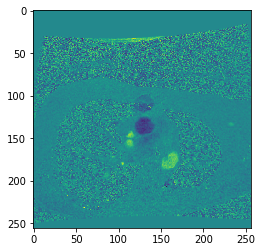

In [36]:
py.imshow(img.pixel_array)

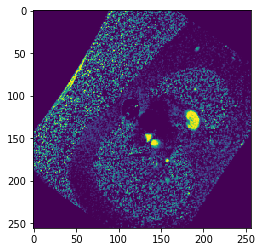

In [37]:
py.imshow(img_align)

In [94]:
lx,ly = img_align.shape

In [124]:
assert(lx==ly)
xm,ym = np.where(lab_align>0) #127 # Get all nonzero entries in the label 
if xm.size<30:
    xm,ym = lx//2,ly//2;
xm = np.mean(xm);
ym = np.mean(ym);

In [171]:
delta = int(lx*.62)//2 #.62 #delta is the desired crop length on either side of xm, ym
assert(delta<xm and delta<ym)

In [172]:
xm,ym,delta = int(xm),int(ym),int(delta)

In [173]:
#Crop image and label so out from the center
SZ=256
img_crop = img_align[xm-delta:xm+delta,ym-delta:ym+delta];
lab_crop = lab_align[xm-delta:xm+delta,ym-delta:ym+delta];

In [160]:
#resize the images to 256, 256
cv2.resize(img_crop, (SZ,SZ)), cv2.resize(lab_crop, (SZ,SZ))

(array([[115,  84,  41, ...,   0,   3,   5],
        [128, 108,  82, ...,   7,   4,   3],
        [144, 138, 132, ...,  18,   7,   0],
        ..., 
        [ 19,  12,   3, ...,   0,   0,   0],
        [ 23,  14,   2, ...,   0,   0,   0],
        [ 26,  16,   2, ...,   0,   0,   0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

Image Shape: (158, 158)


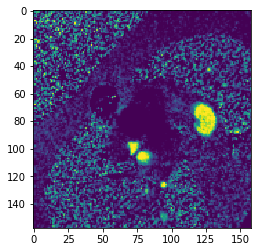

In [214]:
print "Image Shape: %s" %(str(img_crop.shape))
py.imshow(img_crop)

Image Shape: (158, 158)


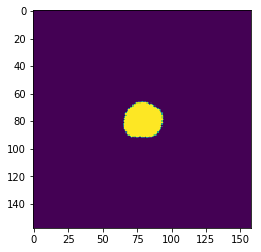

In [213]:
print "Image Shape: %s" %(str(lab_crop.shape))
py.imshow(lab_crop)

Normalizes the SCD and SCD label using get align and gets the images to be the same size

In [194]:
#Creating a function of the above code. Read in the dicom image
def Orientation_M1 (img, label=None):
    if label is None:
        if img.InPlanePhaseEncodingDirection=='COL':
            new_img=cv2.transpose(img.pixel_array)
            #py.imshow(img_new)
            new_img = cv2.flip(new_img, 0)
            return new_img
        else:
            print 'Row Oriented'
            return img.pixel_array
    else:
        if img.InPlanePhaseEncodingDirection=='COL':
            new_img=cv2.transpose(img.pixel_array)
            #py.imshow(img_new)
            new_img = cv2.flip(new_img, 0)
            new_label=cv2.transpose(label)
            new_label=cv2.flip(new_label,0)
            return new_img, new_label
        else:
            print 'Row Oriented'
            return img.pixel_array, label

In [196]:
img_rot,lab_rot=Orientation_M1(img,label)

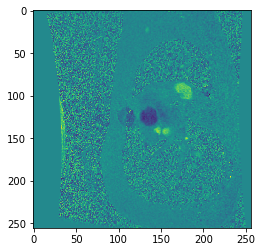

In [197]:
py.imshow(img_rot)

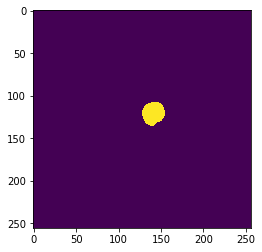

In [198]:
py.imshow(lab_rot)

In [201]:
def reScale(img,label, scale):
    return cv2.resize(img, (0, 0), fx=scale, fy=scale),cv2.resize(label, (0, 0), fx=scale, fy=scale)

In [202]:
scale=img.PixelSpacing[0]
scale

'1.3672'

In [203]:
img_rescale,lab_rescale=reScale(img_rot, lab_rot,scale)

Image Shape: (350, 350)


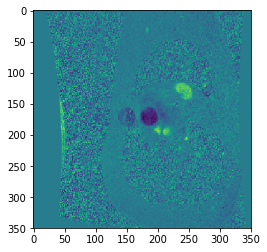

In [206]:
print "Image Shape: %s" %(str(img_rescale.shape))
py.imshow(img_rescale)

Image Shape: (350, 350)


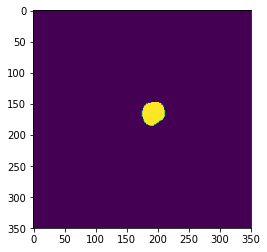

In [207]:
print "Image Shape: %s" %(str(lab_rescale.shape))
py.imshow(lab_rescale)

In [208]:
def get_square_crop(img, base_size=256, crop_size=256):
    res = img
    height, width = res.shape
    if height < base_size:
        diff = base_size - height
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, extend_top, extend_bottom, 0, 0, borderType=cv2.BORDER_CONSTANT, value=0)
        height = base_size

    if width < base_size:
        diff = base_size - width
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, 0, 0, extend_top, extend_bottom, borderType=cv2.BORDER_CONSTANT, value=0)
        width = base_size

    crop_y_start = (height - crop_size) / 2
    crop_x_start = (width - crop_size) / 2
    res = res[crop_y_start:(crop_y_start + crop_size), crop_x_start:(crop_x_start + crop_size)]
    return res

In [209]:
img_crop2=get_square_crop(img_rescale)
lab_crop2=get_square_crop(lab_rescale)

Image Shape: (256, 256)


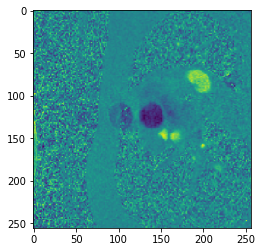

In [212]:
print "Image Shape: %s" %(str(img_crop2.shape))
py.imshow(img_crop2)

Image Shape: (256, 256)


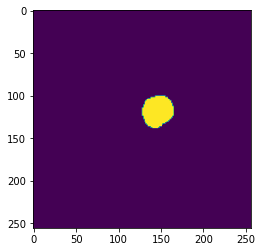

In [210]:
print "Image Shape: %s" %(str(lab_crop2.shape))
py.imshow(lab_crop2)